In [3]:
import pandas as pd
from scipy import stats
import seaborn as sns

In [8]:
%ls files

 Volume in drive C has no label.
 Volume Serial Number is 9C71-F73D

 Directory of C:\Users\maxxo_000\Kaggle\Bosch\files

31.08.2016  16:50    <DIR>          .
31.08.2016  16:50    <DIR>          ..
31.08.2016  16:47        11.281.556 sample_submission.csv
31.08.2016  16:50     2.137.286.201 test_numeric.csv
31.08.2016  16:49     2.139.901.506 train_numeric.csv
               3 File(s)  4.288.469.263 bytes
               2 Dir(s)  98.008.809.472 bytes free


In [14]:
train_num = pd.read_csv("files/train_numeric.csv", usecols=["L0_S0_F0","Response"])

In [16]:
train_num.head(5)

,L0_S0_F0,Response
0,0.030,0
1,NaN,0
2,0.088,0
3,-0.036,0
4,-0.055,0


In [28]:
new = train_num.dropna()

In [29]:
gb = new.groupby("Response")

In [9]:
%matplotlib inline

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


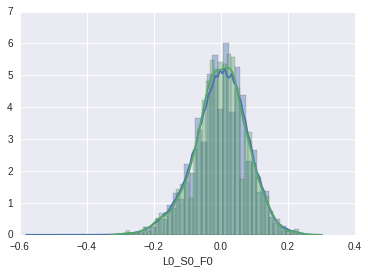

In [31]:
for g in gb.groups:
    sns.distplot(gb.get_group(g)["L0_S0_F0"], hist = True, label = "%i".format(g))

# Strategy:
* Build a multidimensional p-value from measurements and see how it is distributed (?)
* Find confidence interval, or cut on p-value that reduces dataset significantly (minimizing most important confusion matrix entry loss (fnr?))
* Predict remaining dataset with MVA classifier.

In [42]:
# first step is to get the mean and std values for each feature...
train_num = pd.read_csv("files/train_numeric.csv", usecols=["Response"])

In [73]:
train_num.Response.value_counts().apply(lambda x: 1e2*x/len(train_num))

0    99.418879
1     0.581121
Name: Response, dtype: float64

### So there are only 0.58 % of pieces failing the quality control

In [18]:
cols = train_num.drop(["Response","Id"],axis=1).columns

In [35]:
len(cols)

968

In [34]:
?t.std()

In [37]:
from time import time as tt

In [120]:
l+[33]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 33]

In [116]:
slices=[[0,300],[300,600],[600,900],[900,len(cols)]]

In [122]:
for i,sl in enumerate(slices):
    s = tt()
    t = pd.read_csv("files/train_numeric.csv"
                    , usecols=cols[sl[0]:sl[1]].tolist()+["Response"])
    t = t[t.Response==0]
    r = tt()
    print("reading: ", r-s, " seconds")
    if i==0:
       std = pd.DataFrame(t.std())
       mean = pd.DataFrame(t.mean())
    else:
        std = pd.concat([std,pd.DataFrame(t.std())])
        mean = pd.concat([mean,pd.DataFrame(t.mean())])
    print("calc: ", tt()-r, " seconds")
    print("overall: ", tt()-s, " seconds for slice ", i+1,"/",len(slices))
    

reading:  86.87468576431274  seconds
calc:  73.76413941383362  seconds
overall:  160.65445041656494  seconds for slice  1 / 4
reading:  86.17608165740967  seconds
calc:  57.93268084526062  seconds
overall:  144.1087625026703  seconds for slice  2 / 4
reading:  116.40056347846985  seconds
calc:  85.42202687263489  seconds
overall:  201.83821606636047  seconds for slice  3 / 4
reading:  44.424741983413696  seconds
calc:  6.867697477340698  seconds
overall:  51.292439460754395  seconds for slice  4 / 4


* 2 columns take 34s
* 4 cols take 35.2s (vs 0.16 s calc)
* 10 cols take 35.8s (vs 0.35 s calc)

In [131]:
gaus_pars = pd.concat([mean,std], axis=1)
gaus_pars.columns = ["mean","std"]
gaus_pars["LSF_tag"] = gaus_pars.index.values
gaus_pars.index = range(len(gaus_pars))
gaus_pars = gaus_pars[["LSF_tag","mean","std"]]
gaus_pars.head(2)

,LSF_tag,mean,std
0,L0_S0_F0,0.000057,0.080228
1,L0_S0_F2,0.000084,0.092812


In [132]:
#gaus_pars.to_csv("files/lsf_mean_std.csv")

## Calculate multidimensional p value

Here we need to calculate the p value per row.

In [143]:
gaus_pars.

TypeError: get_values() takes 1 positional argument but 2 were given